# Signal Distribution Dataset

This notebook implements the generation of the custom dataset used in the experiments.

## Dataset specification

The dataset consists of artificially generated graphs, where nodes represent distribution points and edges represent connections. Each node has a set of features, being a 1-hot encoding of the strength of the source of signal / distractor at that point. We assume that source of signal $v$ distributes signal to all points located in a radius of $k_v$, where $k_v$ is the strength of source $v$, with the strenth decreasing by 1 as the distance from the source increases by 1. Analogously, the distractors affect points lying in at most $|k_v|$ distance from the distractor, where $k_v$ is the strength of the distractor. The strength of the distractor is negative, and the strength of the signal is positive. 

The targets are binary labels, where a label of 1 means that there is a signal at the point (the cumulative power of signal sources at that exceeds the strength of distraction at that point).

## Dataset generation

To cover a wider spectrum of experiments, we generate several datasets, changing the main specification parameters:
- $k_{max}$ - the maximum value of $|k_v|$
- ${\rho}_{source}$ - the probability distribution of a node being a source of a given strength

For each such dataset, we generate $1000$ graphs. The graphs are taken from the PATTERN dataset, and the features are generated randomly, according to the pre-defined probability distribution. The labels are then generated according to the specification.

In [35]:
#@title [RUN] Import modules
import numpy as np
import seaborn as sns
import math
import itertools
import scipy as sp
import random
import copy

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch_geometric
from torch_geometric.datasets import Planetoid, ZINC, GNNBenchmarkDataset, FakeDataset
from torch_geometric.data import DataLoader, Data, Batch, Dataset
from torch_scatter import scatter_mean, scatter_max, scatter_sum
from torch_geometric.utils import to_dense_adj
from torch.nn import Embedding

import pdb

from tqdm import tqdm

#for nice visualisations
import networkx as nx
import matplotlib.pyplot as plt

from mycolorpy import colorlist as mcp
import matplotlib.cm as cm

from typing import Mapping, Tuple, Sequence, List
import colorama

import scipy.linalg
from scipy.linalg import block_diag

from models.kpath_gnn import kPathGNN

In [91]:
from datasets.sddataset.sddataset import SDDataset

## Visualisation

In [36]:
# @title [RUN] Helper functions for plots and visualisations

####### VISUALISATIONS #######

def draw_one_graph(ax, edges, label=None, node_emb=None, layout=None, special_color=False):
    """draw a graph with networkx based on adjacency matrix (edges)
    graph labels could be displayed as a title for each graph
    node_emb could be displayed in colors
    """
    graph = nx.Graph()
    edges = zip(edges[0], edges[1])
    graph.add_edges_from(edges)
    node_pos = layout(graph)
    #add colors according to node embeding
    if (node_emb is not None) or special_color:
        color_map = []
        node_list = [node[0] for node in graph.nodes(data = True)]
        for i,node in enumerate(node_list):
            #just ignore this branch
            if special_color:
                if len(node_list) == 3:
                    crt_color = (1,0,0)
                elif len(node_list) == 5:
                    crt_color = (0,1,0)
                elif len(node_list) == 4:
                    crt_color = (1,1,0)
                else:
                  special_list = [(1,0,0)] * 3 + [(0,1,0)] * 5 + [(1,1,0)] * 4
                  crt_color = special_list[i]
            else:
                crt_node_emb = node_emb[node]
                #map float number (node embeding) to a color
                crt_color = cm.gist_rainbow(crt_node_emb, bytes=True)
                crt_color = (crt_color[0]/255.0, crt_color[1]/255.0, crt_color[2]/255.0, crt_color[3]/255.0)
            color_map.append(crt_color)
      
        nx.draw_networkx_nodes(graph,node_pos, node_color=color_map,
                        nodelist = node_list, ax=ax)
        nx.draw_networkx_edges(graph, node_pos, ax=ax)
        nx.draw_networkx_labels(graph,node_pos, ax=ax)
    else:
        nx.draw_networkx(graph, node_pos, ax=ax)

def gallery(graphs, labels=None, node_emb=None, special_color=False, max_graphs=4, max_fig_size=(40, 10), layout=nx.layout.kamada_kawai_layout):
    ''' Draw multiple graphs as a gallery 
    Args:
      graphs: torch_geometrics.dataset object/ List of Graph objects
      labels: num_graphs
      node_emb: num_graphs* [num_nodes x num_ch]
      max_graphs: maximum graphs display
    '''
    num_graphs = min(len(graphs), max_graphs)
    ff, axes = plt.subplots(1, num_graphs,
                            figsize=max_fig_size,
                            subplot_kw={'xticks': [], 'yticks': []})
    if num_graphs == 1:
        axes = [axes]
    if node_emb is None:
        node_emb = num_graphs*[None]
    if labels is None:
        labels = num_graphs * [" "]


    for i in range(num_graphs):
        draw_one_graph(axes[i], graphs[i].edge_index.numpy(), labels[i], node_emb[i], layout, special_color)
        if labels[i] != " ":
            axes[i].set_title(f"Target: {labels[i]}", fontsize=28)
        axes[i].set_axis_off()
    plt.show()

def hash_node_embedings(node_emb):
  """ Hash the tensor representing nodes' features 
  to a number in [0,1] used to represent a color

  Args:
    node_emb: list of num_graphs arrays, each of dim (num_nodes x num_feats)
  Returns:
    list of num_graphs arrays in [0,1], each of dim (num_nodes) 
  """
  chunk_size_graph = [x.shape[0] for x in node_emb]
  start_idx_graph = [0] + list(itertools.accumulate(chunk_size_graph))[:-1]
  hash_kernel = np.random.randn(node_emb[0].shape[1])
  node_emb_flatten = np.array([x.dot(hash_kernel) for x in node_emb]).flatten()
  min_emb = node_emb_flatten.min()
  max_emb = node_emb_flatten.max()
  node_emb_flatten = (node_emb_flatten-min_emb)/(max_emb-min_emb+1e-8)


  #split in graphs again according to (start_idx_graph, chunk_size_graph)
  node_emb_hashed = [node_emb_flatten[i:i+l] for (i,l) in zip(start_idx_graph, chunk_size_graph)]
  return node_emb_hashed


def visualize_graph(graph):
    print(graph)
    gallery([graph], node_emb=hash_node_embedings([graph.x.numpy()]))
    gallery([graph], node_emb=hash_node_embedings([graph.y.unsqueeze(1).numpy()]))

####### PLOTS #######

def update_stats(training_stats, epoch_stats):
    """ Store metrics along the training
    Args:
      epoch_stats: dict containg metrics about one epoch
      training_stats: dict containing lists of metrics along training
    Returns:
      updated training_stats
    """
    if training_stats is None:
        training_stats = {}
        for key in epoch_stats.keys():
            training_stats[key] = []
    for key,val in epoch_stats.items():
        training_stats[key].append(val)
    return training_stats

def plot_stats(training_stats, figsize=(5, 5), name=""):
    """ Create one plot for each metric stored in training_stats
    """
    stats_names = [key[6:] for key in training_stats.keys() if key.startswith('train_')]
    f, ax = plt.subplots(len(stats_names), 1, figsize=figsize)
    if len(stats_names)==1:
        ax = np.array([ax])
    for key, axx in zip(stats_names, ax.reshape(-1,)):
        axx.plot(
            training_stats['epoch'],
            training_stats[f'train_{key}'],
            label=f"Training {key}")
        axx.plot(
            training_stats['epoch'],
            training_stats[f'val_{key}'],
            label=f"Validation {key}")
        axx.set_xlabel("Training epoch")
        axx.set_ylabel(key)
        axx.legend()
    plt.title(name)


def get_color_coded_str(i, color):
    return "\033[3{}m{}\033[0m".format(int(color), int(i))

def print_color_numpy(map, list_graphs):
    """ print matrix map in color according to list_graphs
    """
    list_blocks = []
    for i,graph in enumerate(list_graphs):
        block_i = (i+1)*np.ones((graph.num_nodes,graph.num_nodes))
        list_blocks += [block_i]
    block_color = block_diag(*list_blocks)
    
    map_modified = np.vectorize(get_color_coded_str)(map, block_color)
    print("\n".join([" ".join(["{}"]*map.shape[0])]*map.shape[1]).format(*[x for y in map_modified.tolist() for x in y]))
  

## Dataset generation tools

In [37]:
def propagate_signal(graph, signal):
	"""Propagate signal through the graph"""

	strength = torch.zeros(graph.num_nodes)
	used = torch.zeros(graph.num_nodes)

	neighbors = [[] for _ in range(graph.num_nodes)]
	for i in range(graph.num_edges):
		neighbors[graph.edge_index[0][i]].append(graph.edge_index[1][i])
		neighbors[graph.edge_index[1][i]].append(graph.edge_index[0][i])

	for i in range(graph.num_nodes):
		used = torch.zeros(graph.num_nodes)
		queue = [(i, signal[i])]
		while len(queue) > 0:
			node, sgn = queue.pop(0)
			if used[node] == 1 or sgn == 0:
				continue
			used[node] = 1
			strength[node] += sgn
			step = -1 if sgn > 0 else 1
			for neighbor in neighbors[node]:
				queue.append((neighbor, sgn+step))
	
	return (strength>0).long(), strength

In [38]:
class SDDataset(Dataset):
	def __init__(self, k_max=5, rho=None, transform=None, pre_transform=None,
				 num_graphs=1000, avg_num_nodes=100, avg_degree=6):
		super().__init__(None, transform, pre_transform)
		
		self.k_max = k_max
		
		self.rho = rho
		if self.rho is None:
			self.rho = np.ones(2*k_max+1)/(2*k_max+1)
		if self.rho.shape[0] != 2*k_max+1:
			raise ValueError("rho must have length k_max+1")
		self.rho = self.rho/np.sum(self.rho)

		self.fake_data = FakeDataset(num_graphs = num_graphs, avg_num_nodes=avg_num_nodes, avg_degree=avg_degree, num_channels=k_max, num_classes = 2, task='node')
		self.data = []

		for i in tqdm(range(len(self.fake_data))):
			graph = self.fake_data.get(i)
			graph = self.prepare(graph)
			self.data.append(graph)

	def prepare(self, graph):
		
		# Generate node features
		features = np.random.choice(list(range(-self.k_max, self.k_max+1)), size=graph.num_nodes, p=self.rho)
		onehot_features = np.zeros((graph.num_nodes, 2*self.k_max+1))
		onehot_features[np.arange(graph.num_nodes), features+self.k_max] = 1
		graph.x = torch.from_numpy(onehot_features).float()
		
		# Generate node labels
		graph.y, _ = propagate_signal(graph, features)
		return graph

	def len(self):
		return len(self.fake_data)
	
	def get(self, idx):
		return self.data[idx]


## Generate the dataset

In [39]:
k_max = 5
rho = np.array([1,2,4,8,16,128,16,8,4,2,1])

In [94]:
dataset = SDDataset(load_path='datasets/sddataset/k5_g1000/', k_max=k_max, rho=rho, num_graphs=1000, avg_num_nodes=100, avg_degree=4)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:00<00:00, 12820.58it/s]


(array([-3, -2, -1,  0,  1,  2,  3,  4], dtype=int64), array([ 1,  7,  8, 47,  6,  6,  3,  1], dtype=int64))
tensor(4) tensor(75)
Data(x=[79, 11], edge_index=[2, 610], y=[79])


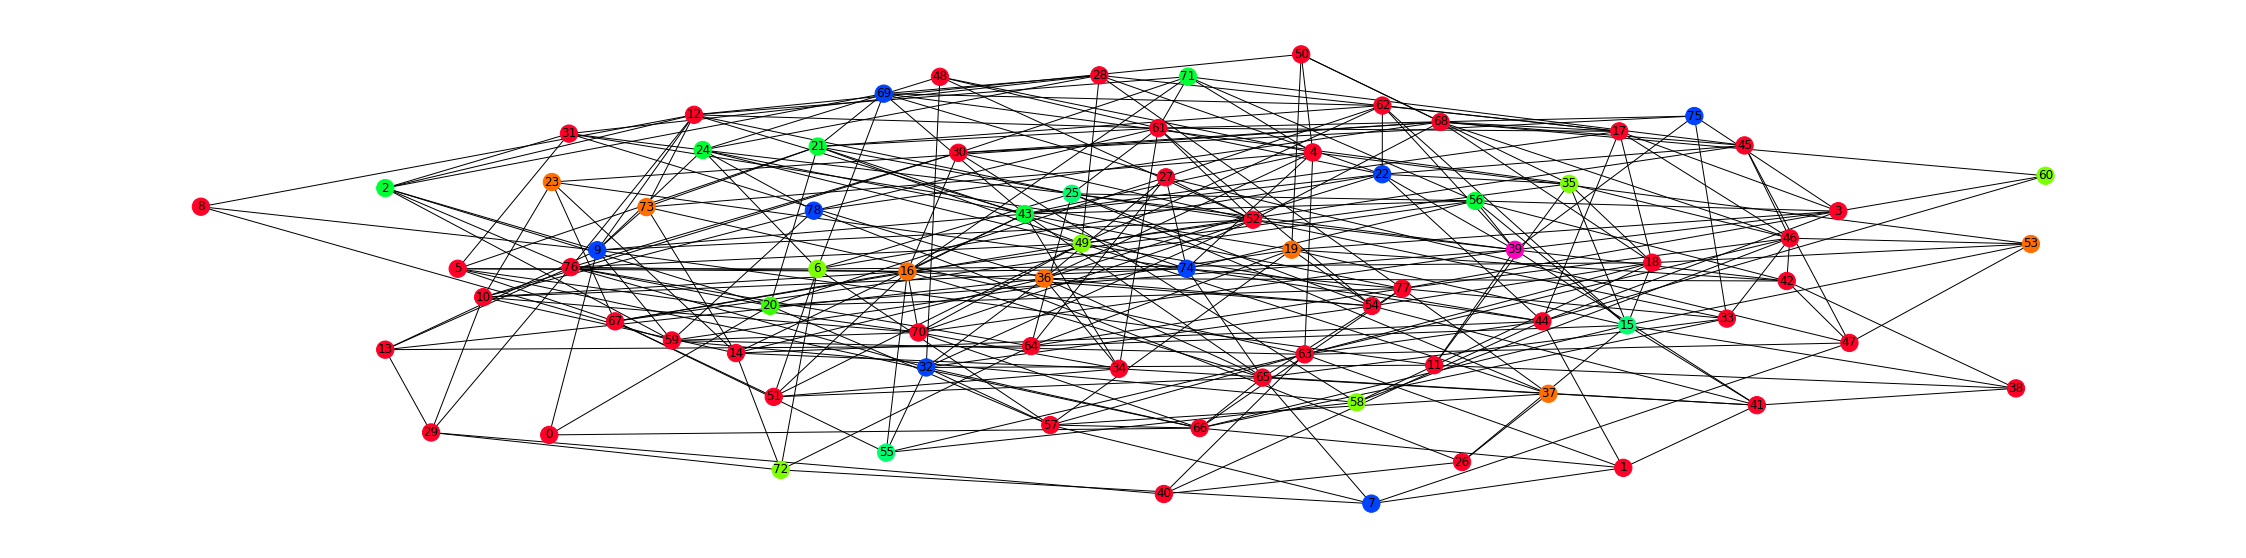

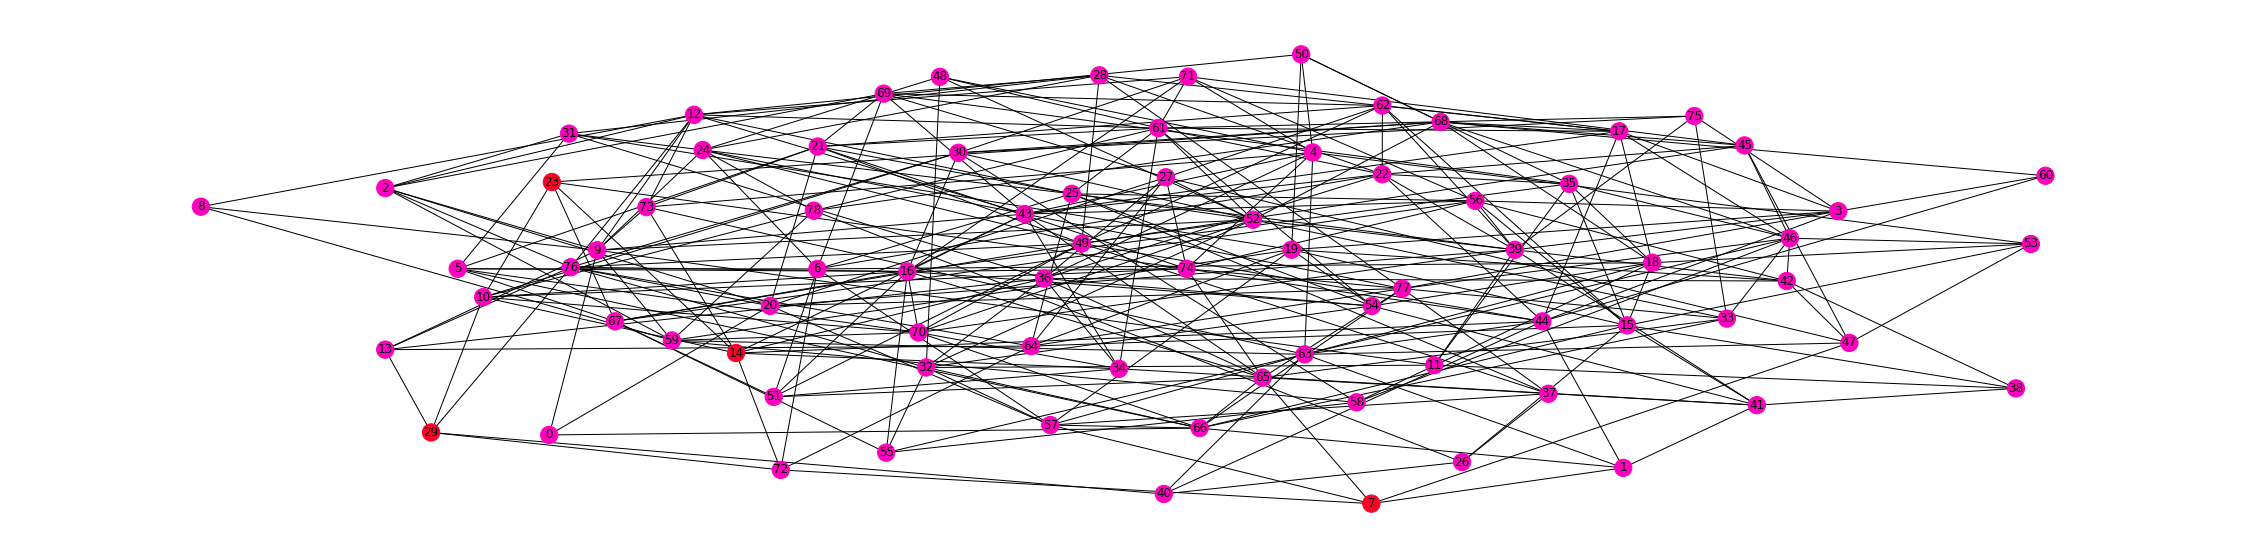

In [93]:
# Analyze the dataset

graph = dataset.get(0)
degrees = torch.argmax(graph.x, dim=1)-k_max
print(np.unique(degrees.numpy(), return_counts=True))
print((graph.y==0).sum(), (graph.y==1).sum())
visualize_graph(graph)

Data(x=[7, 11], edge_index=[2, 6], y=[7])


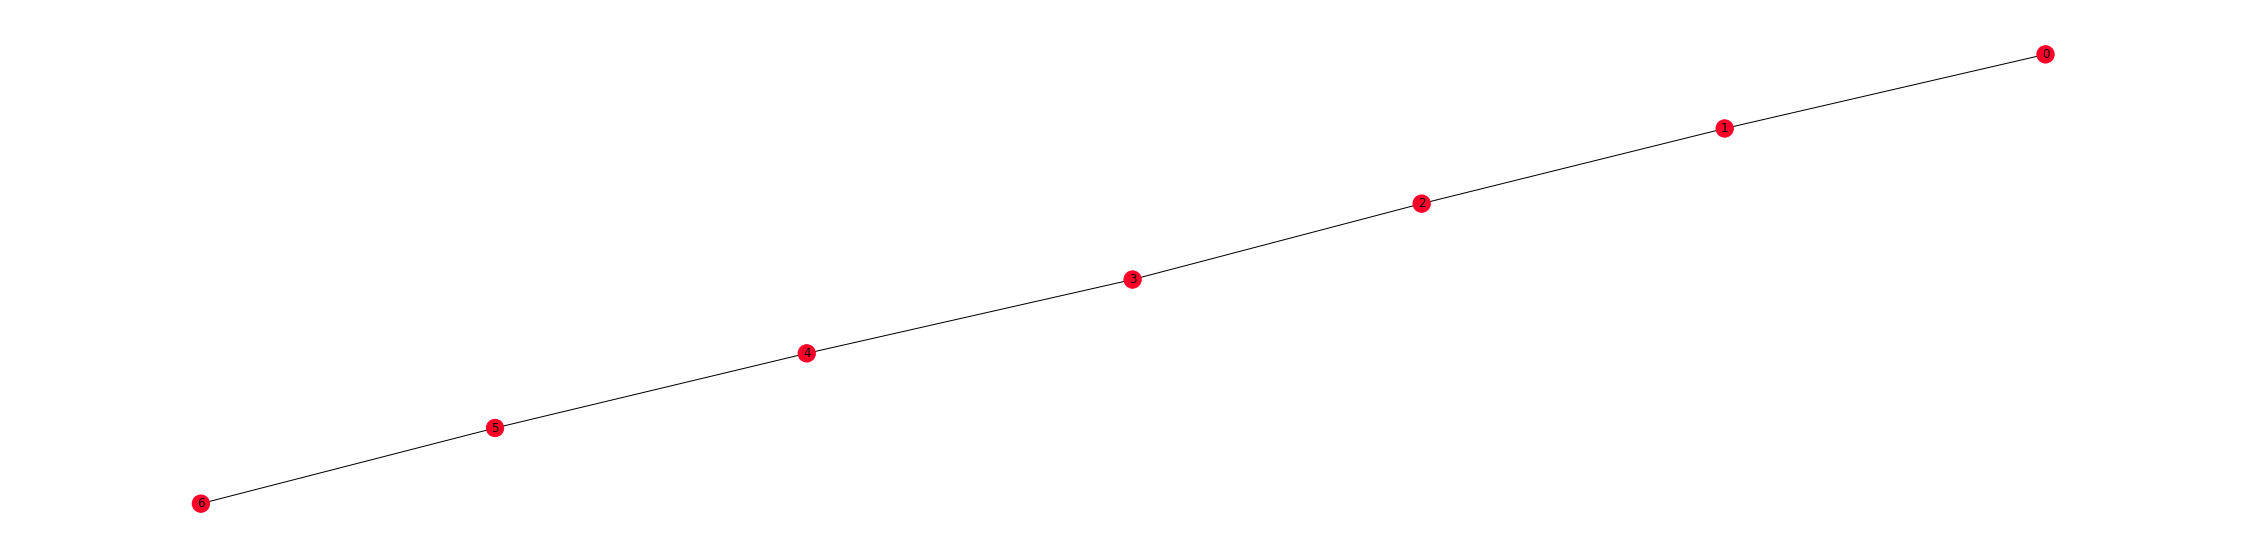

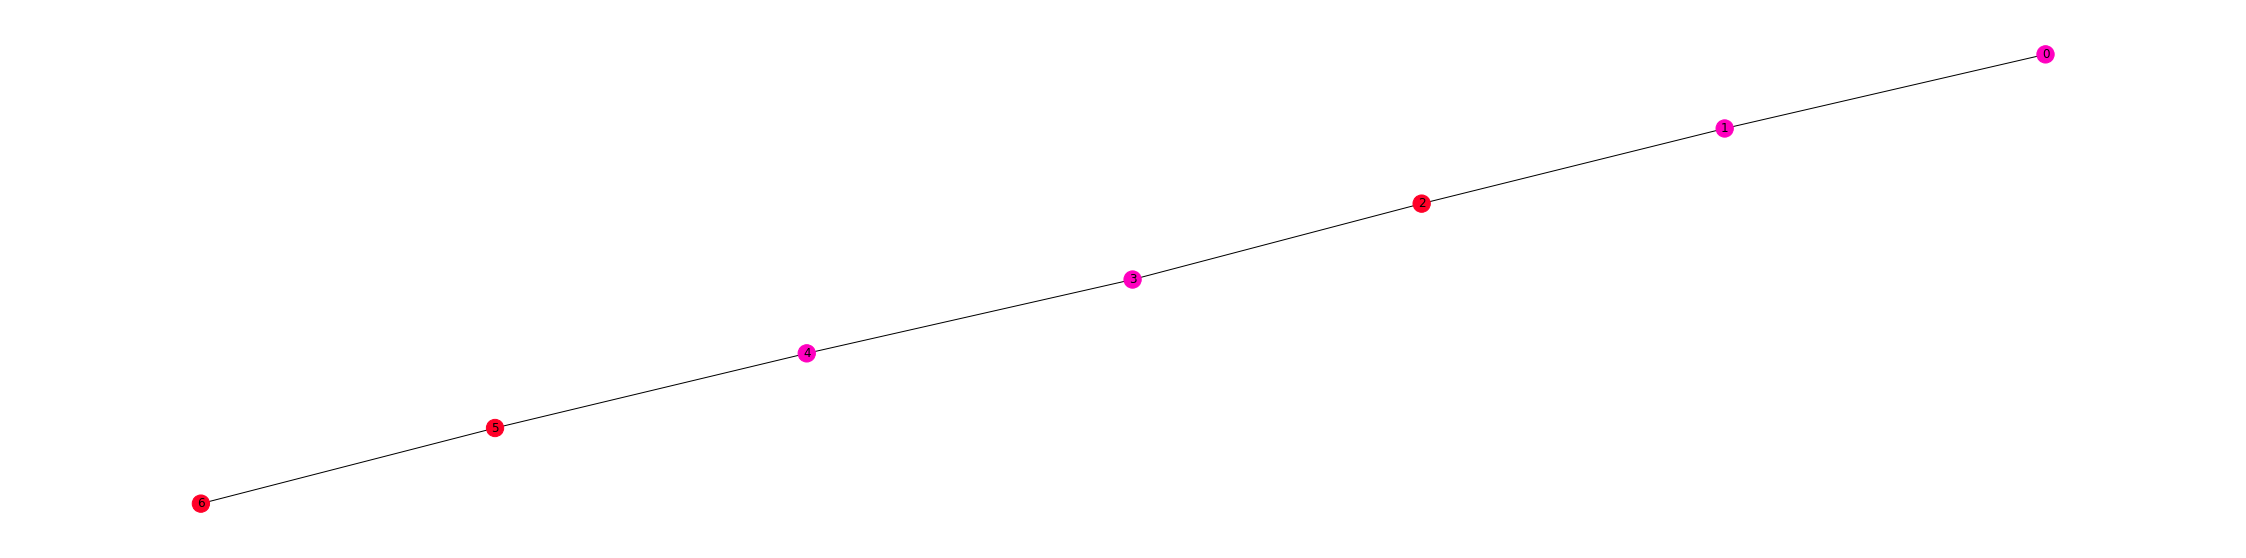

In [42]:
line_graph = Data(x = torch.zeros(7, 2*k_max+1), edge_index = torch.tensor([[0,1,2,3,4,5], [1,2,3,4,5,6]]))
line_graph.y, _ = propagate_signal(line_graph, torch.tensor([4,0,-2,0,2,0,-3]))
visualize_graph(line_graph)

## Validation Tools

In [43]:
train_split = 800
valid_split = 900
test_split  = 1000

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using device: ", device)

Using device:  cuda


In [44]:
def validate_model(model):
	model.eval()
	pred = []
	for i in range(train_split, valid_split):
		graph = dataset.get(i).to(device)
		pred.append(model(graph, valid = True)==graph.y)
	pred = torch.cat(pred, dim=0).float()
	
	perc = pred.mean().item()*100

	mess = f"{perc:.2f}%"
	return perc, mess

def test_model(model):
	model.eval()
	pred = []
	for i in range(valid_split, test_split):
		graph = dataset.get(i).to(device)
		pred.append(model(graph, valid = True)==graph.y)
	pred = torch.cat(pred, dim=0).float()
	
	perc = pred.mean().item()*100

	print(f"Test accuracy: {perc:.2f}%")
	return perc

def evaluate_model(model):
	val_acc = validate_model(model)
	test_acc = test_model(model)

	return val_acc, test_acc

## Training tools

In [45]:
def create_mini_batch(graph_list):
    batch_edge_index = graph_list[0].edge_index
    batch_x = graph_list[0].x
    batch_y = graph_list[0].y
    batch_batch = torch.zeros((graph_list[0].num_nodes), dtype=torch.int64)

    nodes_count = graph_list[0].num_nodes

    for idx, graph in enumerate(graph_list[1:]):
        batch_x = torch.cat((batch_x, graph.x))
        batch_y = torch.cat((batch_y, graph.y))

        batch_edge_index = torch.cat((
            batch_edge_index, 
            torch.add(graph.edge_index, nodes_count))
        , dim=1)
        nodes_count += graph.num_nodes

        batch_batch = torch.cat((
            batch_batch, 
            torch.full((graph.num_nodes,), idx + 1)
        ))

    batch_graph = Data(x=batch_x, edge_index=batch_edge_index, y=batch_y, batch=batch_batch)
    return batch_graph

In [46]:
def train(model, epochs, batch_size, lr, weight_decay=0, print_interval=10, valid_interval=10):

	optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
	criterion = torch.nn.CrossEntropyLoss()

	best_model = None
	best_val_acc = 0

	total_losses = []
	val_accuracies = []

	for epoch in range(epochs):
		model.train()
		losses = []
		perm = torch.randperm(train_split)
		for i in range(0, train_split, batch_size):
			optimizer.zero_grad()
			graph_list = [dataset.get(perm[i+j]) for j in range(batch_size)]
			batch = create_mini_batch(graph_list).to(device)
			pred = model(batch)
			loss = criterion(pred, batch.y)
			loss.backward()
			optimizer.step()
			losses.append(loss.item())
		
		total_losses.append(np.mean(losses))

		if (epoch+1)%valid_interval==0:
			val_acc, mess = validate_model(model)
			val_accuracies.append(val_acc)
			if val_acc > best_val_acc:
				best_val_acc = val_acc
				best_model = copy.deepcopy(model)

		if (epoch+1)%print_interval==0:
			message = f"Epoch {epoch+1}/{epochs}:   loss: {np.mean(losses):.4f}"
			message += " - val_acc: " + str(mess)
			print(message)

	plt.plot(losses, label="Training loss")
	plt.show()

	plt.plot(list(range(0, epochs, valid_interval)), val_accuracies, label="Validation accuracy")
	plt.show()

	evaluate_model(best_model)
	return best_model

## Training

### GCN

In [47]:
from torch_geometric.nn import GCNConv
from torch_geometric.nn.models import GCN

class GCNModel(nn.Module):
	def __init__(self) -> None:
		super().__init__()

		self.convs = nn.ModuleList()

		self.convs.append(GCNConv(2*k_max+1, 16))
		self.convs.append(GCNConv(16, 16))
		self.convs.append(GCNConv(16, 16))
		self.convs.append(GCNConv(16, 2))


		self.sigmoid = nn.Sigmoid()
		self.softmax = nn.Softmax(dim=1)
		self.relu = nn.ReLU()

	def forward(self, graph, valid = False):
		
		x = graph.x
		
		for layer in self.convs[:-1]:
			x = self.relu(layer(x, graph.edge_index))
		
		x = self.convs[-1](x, graph.edge_index)
		x = self.softmax(30*x)

		if valid:
			x = torch.argmax(x, dim=1)
		return x

Epoch 10/100:   loss: 0.4243 - val_acc: 89.13%
Epoch 20/100:   loss: 0.4292 - val_acc: 89.59%
Epoch 30/100:   loss: 0.4275 - val_acc: 89.61%
Epoch 40/100:   loss: 0.4213 - val_acc: 89.26%
Epoch 50/100:   loss: 0.4255 - val_acc: 88.23%
Epoch 60/100:   loss: 0.4251 - val_acc: 89.52%
Epoch 70/100:   loss: 0.4220 - val_acc: 89.60%
Epoch 80/100:   loss: 0.4215 - val_acc: 89.56%
Epoch 90/100:   loss: 0.4311 - val_acc: 89.59%
Epoch 100/100:   loss: 0.4227 - val_acc: 89.55%


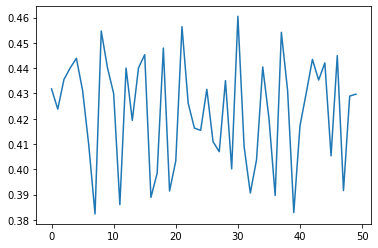

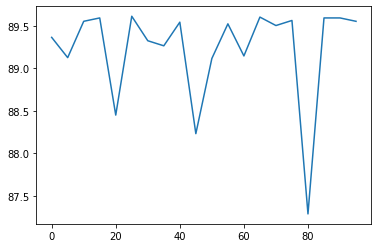

Test accuracy: 89.41%


GCNModel(
  (convs): ModuleList(
    (0): GCNConv(11, 16)
    (1): GCNConv(16, 16)
    (2): GCNConv(16, 16)
    (3): GCNConv(16, 2)
  )
  (sigmoid): Sigmoid()
  (softmax): Softmax(dim=1)
  (relu): ReLU()
)

In [48]:
gcn_model = GCNModel().to(device)
train(gcn_model, epochs=100, batch_size=16, lr=0.007, print_interval=10, valid_interval=5)

### DBGNN

In [49]:
class DBGCNModel(nn.Module):
    
	def __init__(self) -> None:
		super().__init__()

		self.hidden_dim = 16

		self.convs = nn.ModuleList()
		self.convs.append(GCNConv(2*k_max+1, self.hidden_dim))
		self.convs.append(GCNConv(self.hidden_dim, self.hidden_dim))
		self.convs.append(GCNConv(self.hidden_dim, self.hidden_dim))
		self.convs.append(GCNConv(self.hidden_dim, 1))
		
		self.thrs = nn.ModuleList()
		self.thrs.append(GCNConv(2*k_max+1, self.hidden_dim))
		self.thrs.append(GCNConv(self.hidden_dim, self.hidden_dim))
		self.thrs.append(GCNConv(self.hidden_dim, self.hidden_dim))
		self.thrs.append(GCNConv(self.hidden_dim, 1))

		self.sigmoid = nn.Sigmoid()
		self.softmax = nn.Softmax(dim=1)
		self.relu = nn.ReLU()

		self.k = 30


	def forward(self, graph, valid = False):
		
		# Calculate the probability of each node being a tap
		p = graph.x
		for layer in self.convs[:-1]:
			p = self.relu(layer(p, graph.edge_index))
		t = self.thrs[-1](p, graph.edge_index)
		p = self.convs[-1](p, graph.edge_index)

		p = self.sigmoid(p)
		t = self.sigmoid(t)
		
		# Calculate the thresholded probability
		x = 1 / (1 + torch.exp(-self.k * (p - t)))

		# Calculate the final output
		x = torch.stack([1-x, x], dim=1).squeeze()
		if valid:
			x = torch.argmax(x, dim=1)
		return x

Epoch 10/100:   loss: 0.4241 - val_acc: 88.35%
Epoch 20/100:   loss: 0.4228 - val_acc: 89.39%
Epoch 30/100:   loss: 0.4225 - val_acc: 89.12%
Epoch 40/100:   loss: 0.4229 - val_acc: 89.34%
Epoch 50/100:   loss: 0.4215 - val_acc: 89.14%
Epoch 60/100:   loss: 0.4230 - val_acc: 89.43%
Epoch 70/100:   loss: 0.4202 - val_acc: 89.54%
Epoch 80/100:   loss: 0.4219 - val_acc: 89.56%
Epoch 90/100:   loss: 0.4227 - val_acc: 87.51%
Epoch 100/100:   loss: 0.4178 - val_acc: 89.95%


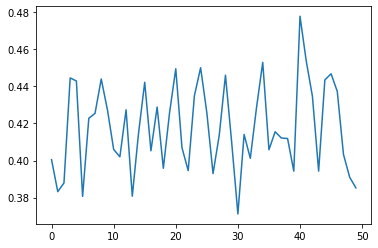

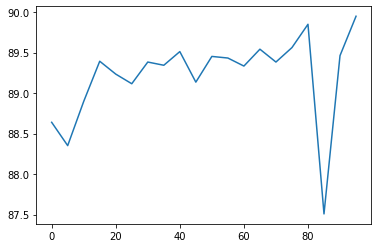

Test accuracy: 89.58%


DBGCNModel(
  (convs): ModuleList(
    (0): GCNConv(11, 16)
    (1): GCNConv(16, 16)
    (2): GCNConv(16, 16)
    (3): GCNConv(16, 1)
  )
  (thrs): ModuleList(
    (0): GCNConv(11, 16)
    (1): GCNConv(16, 16)
    (2): GCNConv(16, 16)
    (3): GCNConv(16, 1)
  )
  (sigmoid): Sigmoid()
  (softmax): Softmax(dim=1)
  (relu): ReLU()
)

In [52]:
dbgcn_model = DBGCNModel().cuda()
train(dbgcn_model, epochs=100, batch_size=16, lr=0.05, print_interval=10, valid_interval=5)

### k-hops GNN

In [54]:
kpgnn_model = kPathGNN(k=4, in_channels=2*k_max+1, hidden_channels=None, out_channels=2, device='cuda')
kpgnn_model = train(kpgnn_model, epochs=100, batch_size=16, lr=0.01, print_interval=10, valid_interval=5)

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument mat1 in method wrapper_addmm)

In [ ]:
print(kpgnn_model.self_layer.linears[0].weight.detach().cpu().numpy())
for i in range(kpgnn_model.k):
	print(kpgnn_model.layers[i].linears[0].weight.detach().cpu().numpy())

In [83]:
x = [graph.x.cpu().numpy() for graph in dataset.data]

In [84]:
np.save('datasets/sddataset/x.npy', np.array(x, dtype=object), allow_pickle=True)

In [88]:
b = np.load('datasets/sddataset/x.npy', allow_pickle=True)

In [90]:
b[0].reshape(-1, 11)

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.

In [ ]:
dataset = 